In [1]:
import sys
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
sys.path.append('../')
from Utils import *
from einops import rearrange


In [2]:
# Read one case from a folder that contains the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/Aorta/Center012/Philips_30T_Ingenia/vn4/'

# load_data takes the case directory (where the .mat files are located) as input
# Returned objects are lazy h5 handles (h5py-style); data is not loaded into memory until indexed
kdata_full = load_data(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap = load_data(data_dir + '/coilmap.mat', key='coilmap')
segmask = load_data(data_dir + '/segmask.mat', key='segmask')
params = read_params_csv(data_dir + '/params.csv')

# For h5 datasets, use [()] to materialize the full array into RAM as a NumPy array
kdata_full = kdata_full['real'][()] + 1j * kdata_full['imag'][()]
coilmap = coilmap['real'][()] + 1j * coilmap['imag'][()]

VENC = np.array(params['VENC'])
VOrder = params['venc_order']
# k-space data shape: (Nv, Nt, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)
Nv, Nt, SPE, PE, FE = img.shape

Mask shape: (1, 25, 1, 20, 96, 1), Actual undersampling rate: 20.00x


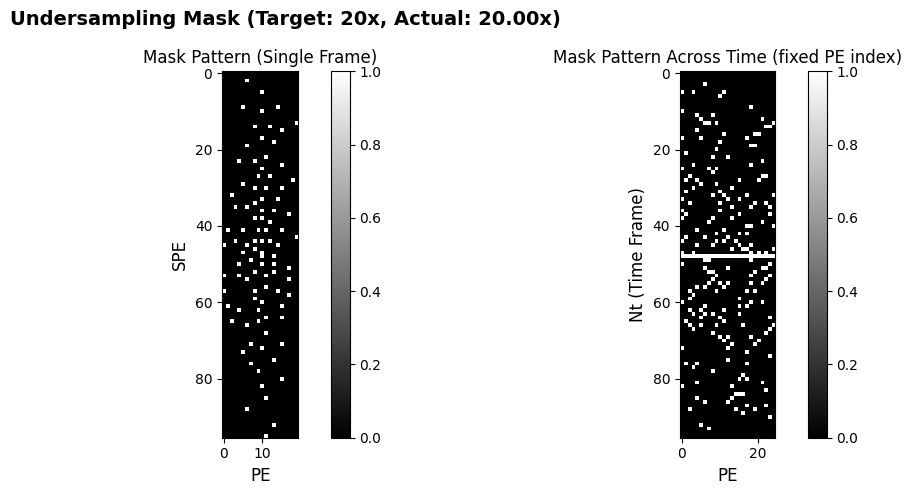

In [3]:
usrate = 20
# target number of sampled points per (PE,SPE) frame
total_points = PE * SPE // usrate

# fun_mask_gen_2d expects mask_size = (PE, SPE)
mask_size = (PE, SPE)

# fully-sampled center control (in your implementation: <=0.5 means force center point = 1)
center_radius_x = 0.5
center_radius_y = 0.5

# Gaussian sampling density (larger -> flatter; smaller -> more center-focused)
sigma_x = PE / 5
sigma_y = SPE / 5

# Generate masks for all time frames:
# output shape is (SPE, PE, Nt)
masks_spe_pe_t = fun_mask_gen_2d(
    mask_size=mask_size,
    center_radius_x=center_radius_x,
    center_radius_y=center_radius_y,
    total_points=total_points,
    pattern_num=Nt,
    sigma_x=sigma_x,
    sigma_y=sigma_y,
    min_dist_factor=3,
    rep_decay_factor=0.5,
)
# Reshape to match the document:
# (SPE, PE, Nt) -> (1, Nt, 1, SPE, PE, 1)
usmask = rearrange(masks_spe_pe_t, 'spe pe t -> 1 t 1 spe pe 1')
actual_usrate = 1.0 / np.mean(usmask)
print(f"Mask shape: {usmask.shape}, Actual undersampling rate: {actual_usrate:.2f}x")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f'Undersampling Mask (Target: {usrate}x, Actual: {actual_usrate:.2f}x)',
    fontsize=14,
    fontweight='bold'
)
# Show one time frame mask: (SPE, PE)
im0 = axes[0].imshow(usmask[0, 0, 0, :, :, 0].T, cmap='gray')
axes[0].set_xlabel("PE", fontsize=12)
axes[0].set_ylabel("SPE", fontsize=12)
axes[0].set_title("Mask Pattern (Single Frame)", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Show temporal variation at one SPE line: (Nt, PE)
im1 = axes[1].imshow(usmask[0, :, 0, SPE//2, :, 0].T, cmap='gray')
axes[1].set_xlabel("PE", fontsize=12)
axes[1].set_ylabel("Nt (Time Frame)", fontsize=12)
axes[1].set_title("Mask Pattern Across Time (fixed PE index)", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

In [4]:
kdata_us = kdata_full * usmask
ksp = rearrange(kdata_us, 'nv nt nc spe pe fe -> nv nc nt fe pe spe')
coils = rearrange(coilmap, 'nc spe pe fe-> nc 1 fe pe spe')
lamb_tv = 0.0
lamb_llr = 0.5
img_csllr = CS_LLR(lamb_tv, lamb_llr, ksp, coils, seg=True)
img_csllr = rearrange(img_csllr, 'nv nt fe pe spe -> nv nt spe pe fe')

/home/caory/miniconda3/envs/ryy/lib/python3.10/site-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/localhome/caory/CMRx4DFlow2026/CMRx4DFlowReconDemo/2_CompressedSensingDemo/../Utils/CS_LLR_utils.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bsz = torch.tensor(bsz, dtype=torch.float32)
/localhome/caory/CMRx4DFlow2026/CMRx4DFlowReconDemo/2_CompressedSensingDemo/../Utils/CS_LLR_utils.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(bsz * torch.ceil(imsz / bsz), dtype=torch.long)


it 0 cost=112545.484375 data_cost 94493.8046875 nuclear_cost 36103.35546875
	time_data=0.023 time_regs=0.016 time_prox=0.093
it 1 cost=95629.3203125 data_cost 76733.328125 nuclear_cost 37791.984375
	time_data=0.002 time_regs=0.001 time_prox=0.060
it 2 cost=80740.7421875 data_cost 60736.20703125 nuclear_cost 40009.07421875
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 3 cost=68747.828125 data_cost 47637.57421875 nuclear_cost 42220.5078125
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 4 cost=59466.67578125 data_cost 37562.86328125 nuclear_cost 43807.625
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 5 cost=52930.109375 data_cost 30114.490234375 nuclear_cost 45631.23828125
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 6 cost=48254.046875 data_cost 24661.60546875 nuclear_cost 47184.87890625
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 7 cost=44561.1796875 data_cost 20687.21875 nuclear_cost 47747.921875
	time_data=0.002 time_regs=0.001 time_prox=0.059
it 8 cost

In [8]:
save_mat('./img_csllr.mat', 'img_csllr', img_csllr)

In [6]:
mag_gt, flow_gt = complex2magflow(img, venc=np.array(VENC))
mag_csllr, flow_csllr = complex2magflow(img_csllr, venc=np.array(VENC))

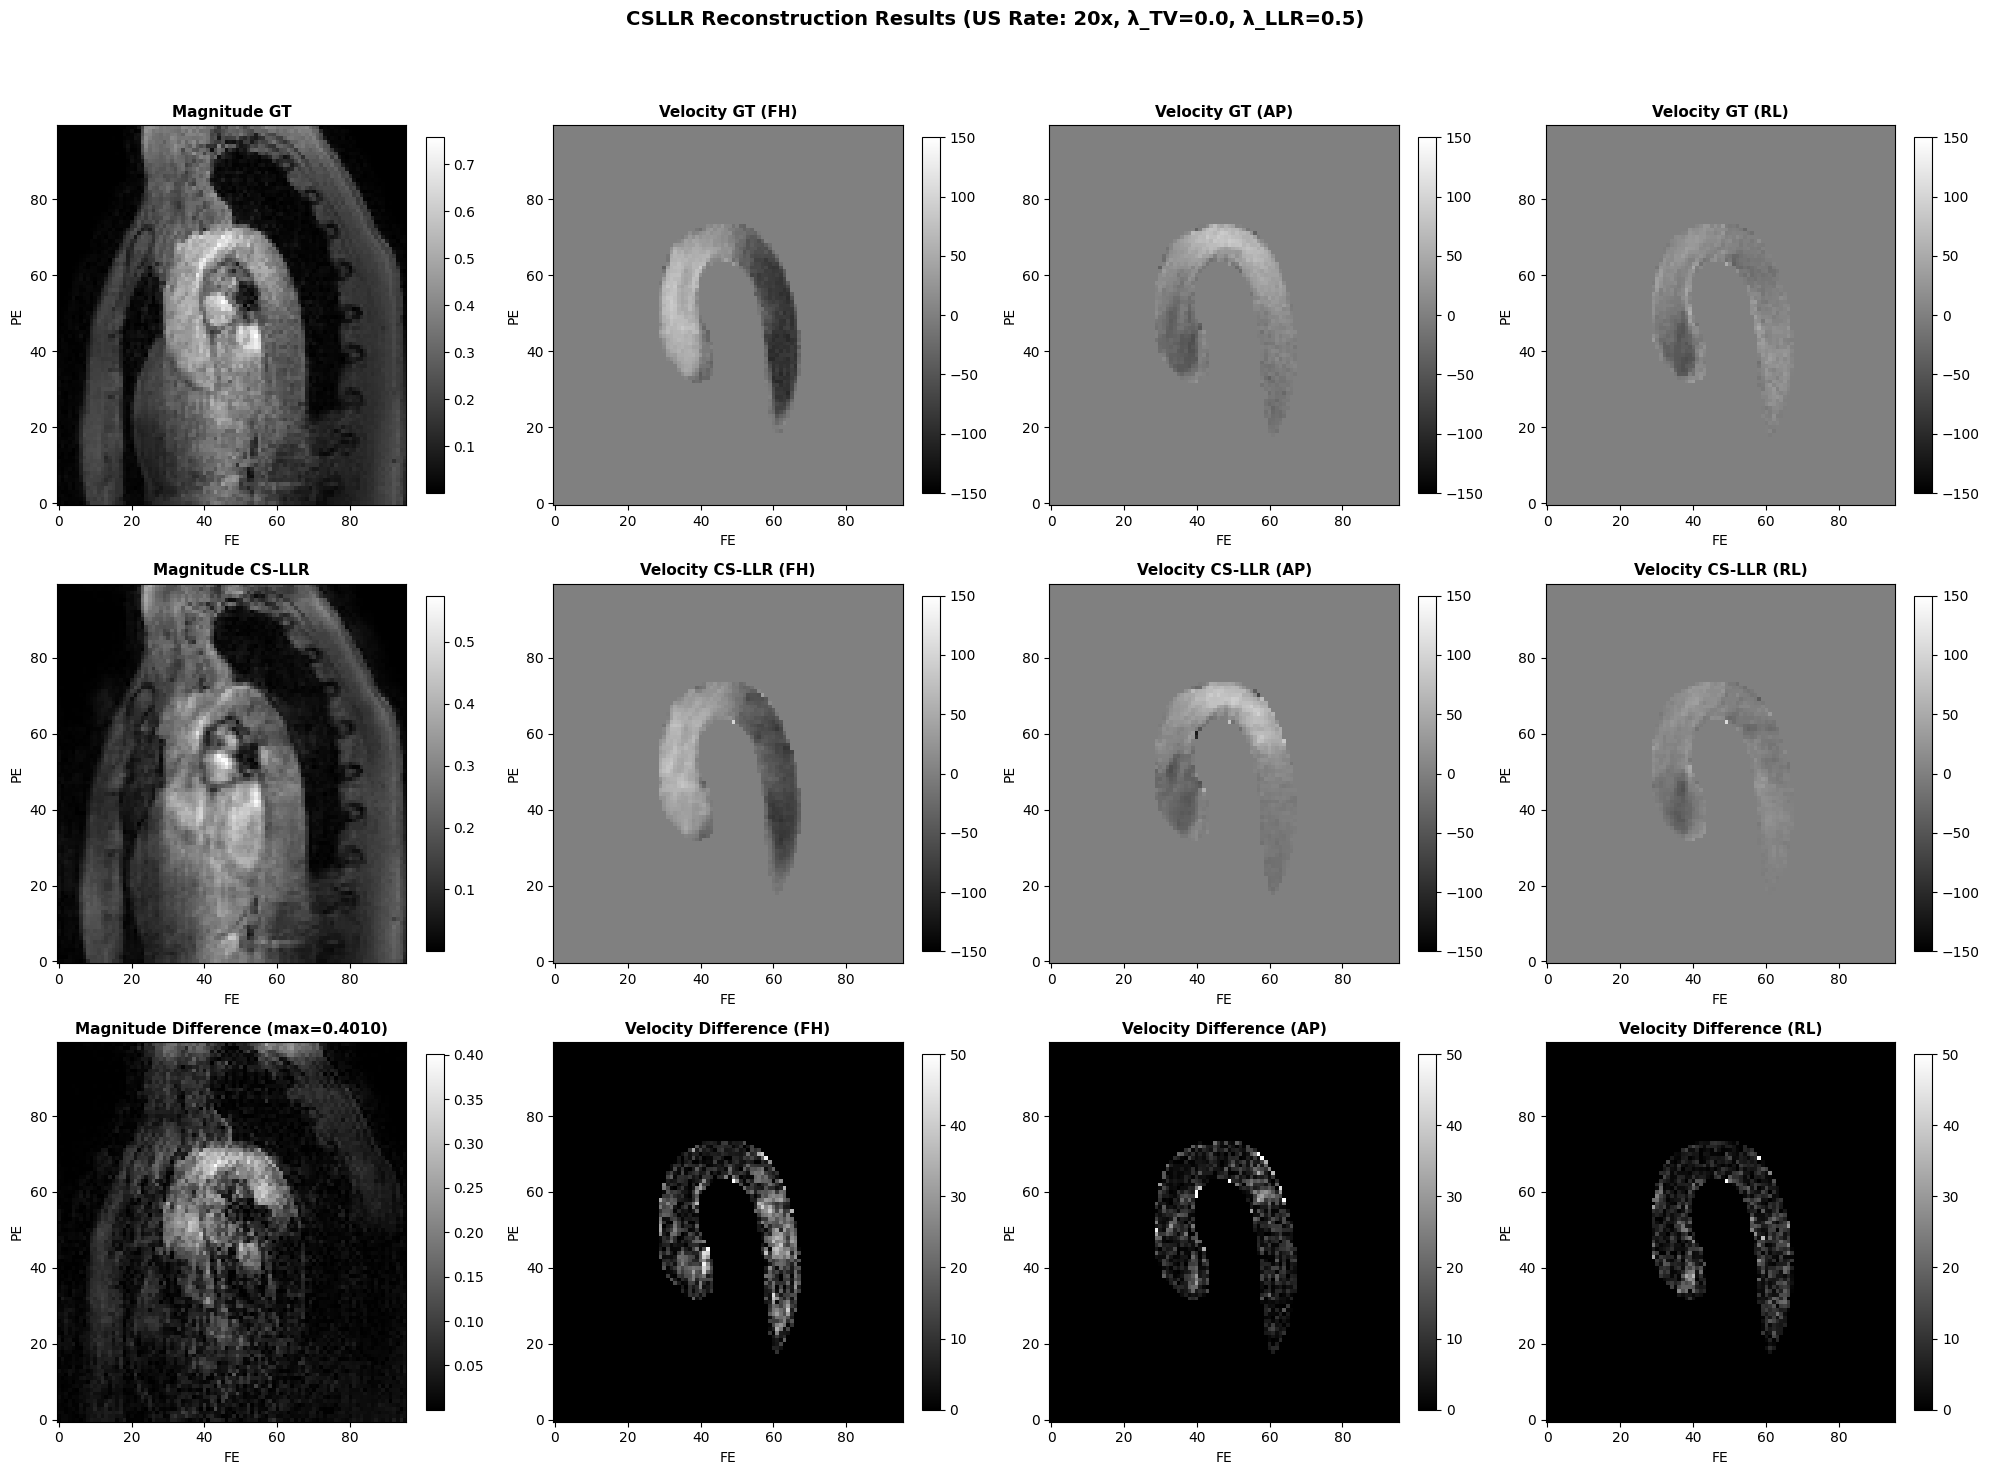

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# complex -> (mag, flow)
mag_gt,    flow_gt    = complex2magflow(img,       venc=np.array(VENC))
mag_csllr, flow_csllr = complex2magflow(img_csllr, venc=np.array(VENC))

# shapes: (Nv, Nt, SPE, PE, FE)
showz = mag_gt.shape[2] // 2   # SPE index
showt = 3                      # Nt index
showv = 0                      # pick v for magnitude (if Nv>1)

row, col = 3, 4
fig = plt.figure(figsize=(20, 15))
fig.suptitle(
    f'CSLLR Reconstruction Results (US Rate: {usrate}x, λ_TV={lamb_tv}, λ_LLR={lamb_llr})',
    fontsize=14, fontweight='bold'
)

def imshow_pefe(ax, img2d, title, vmin=None, vmax=None):
    im = ax.imshow(
        img2d, cmap='gray', origin='lower', aspect='auto',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("FE")
    ax.set_ylabel("PE")
    plt.colorbar(im, ax=ax, fraction=0.046)
    return im

# ---------------- Row 1: GT ----------------
ax1 = plt.subplot(row, col, 1)
imshow_pefe(ax1, np.abs(mag_gt[showv, showt, showz, :, :]).T, "Magnitude GT")

for i in range(3):
    ax = plt.subplot(row, col, i + 2)
    imshow_pefe(
        ax,
        (flow_gt[i, showt, showz, :, :] * segmask[showz]).T.astype(np.float32),
        f"Velocity GT ({VOrder[i]})",
        vmin=-VENC[i], vmax=VENC[i]
    )

# ---------------- Row 2: CSLLR ----------------
ax5 = plt.subplot(row, col, 5)
imshow_pefe(ax5, np.abs(mag_csllr[showv, showt, showz, :, :]).T, "Magnitude CS-LLR")

for i in range(3):
    ax = plt.subplot(row, col, i + 6)
    imshow_pefe(
        ax,
        (flow_csllr[i, showt, showz, :, :] * segmask[showz]).T.astype(np.float32),
        f"Velocity CS-LLR ({VOrder[i]})",
        vmin=-VENC[i], vmax=VENC[i]
    )

# ---------------- Row 3: Difference maps ----------------
mag_diff = np.abs(np.abs(mag_csllr) - np.abs(mag_gt))[showv, showt, showz, :, :]
ax9 = plt.subplot(row, col, 9)
imshow_pefe(ax9, mag_diff.T, f"Magnitude Difference (max={mag_diff.max():.4f})")

for i in range(3):
    ax = plt.subplot(row, col, i + 10)
    flow_diff = np.abs(flow_csllr - flow_gt)[i, showt, showz, :, :] * segmask[showz]
    imshow_pefe(
        ax,
        flow_diff.T.astype(np.float32),
        f"Velocity Difference ({VOrder[i]})",
        vmin=0, vmax=VENC[i] / 3
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()